# Compare Puppi MET and Raw Puppi MET

In [1]:
from coffea.nanoevents import NanoEventsFactory, NanoAODSchema
import awkward as ak
import matplotlib.pyplot as plt
import matplotlib
import vector
import math
import numpy as np
import matplotlib.gridspec as gridspec
vector.register_awkward()

from coffea.jetmet_tools import CorrectedJetsFactory, CorrectedMETFactory

In [2]:
def met_correction_after_jec(events, METcoll, jets_pre_jec, jets_post_jec):
    '''This function rescale the MET vector by minus delta of the jets after JEC correction
    and before the jEC correction.
    This can be used also to rescale the MET when updating on the fly the JEC calibration. '''
    orig_tot_px = ak.sum(jets_pre_jec.px, axis=1)
    orig_tot_py = ak.sum(jets_pre_jec.py, axis=1)
    new_tot_px = ak.sum(jets_post_jec.px, axis=1)
    new_tot_py = ak.sum(jets_post_jec.py, axis=1)
    newpx =  events[METcoll].px - (new_tot_px - orig_tot_px) 
    newpy =  events[METcoll].py - (new_tot_py - orig_tot_py) 
    
    newMetPhi = np.arctan2(newpy, newpx)
    newMetPt = (newpx**2 + newpy**2)**0.5
    return  {"pt": newMetPt, "phi": newMetPhi}



In [3]:
filename="root://xrootd-cms.infn.it///store/mc/Run3Summer22NanoAODv12/DYJetsToLL_M-50_TuneCP5_13p6TeV-madgraphMLM-pythia8/NANOAODSIM/forPOG_130X_mcRun3_2022_realistic_v5-v2/2540000/88d947b3-b5ca-452b-84c1-034b8d6eab66.root"
events = NanoEventsFactory.from_root(filename, schemaclass=NanoAODSchema, entry_stop=1000 ).events()

In [4]:
print(events.RawPuppiMET.pt)
print(events.PuppiMET.pt)

print(events.RawMET.pt)
print(events.MET.pt)

[7.47, 57.9, 25.2, 8.44, 13, 18.4, 30.7, ... 8.96, 16.7, 20.9, 33.2, 40, 20.4, 52.7]
[7.47, 76.5, 45.3, 10.9, 12, 17.7, 30.2, ... 6.71, 19, 34.1, 34.2, 35.9, 21.8, 66]
[77.3, 52.8, 24, 10.7, 8.99, 26.5, 37.2, ... 39.8, 10.2, 28.9, 12.8, 24, 38.9, 37.7]
[80.9, 72.1, 25.7, 13.3, 8.48, 26.9, 42.2, ... 1.33, 34.1, 23.2, 45.3, 42.2, 45.8]


In [5]:
jet_raw = ak.copy(events.Jet)
jet_raw_pt = jet_raw.pt * (
    1 - jet_raw.rawFactor
)  
jet_raw = ak.zip(
    {
        "pt": jet_raw_pt,
        "px": jet_raw_pt * np.cos(jet_raw.phi),
        "py": jet_raw_pt * np.sin(jet_raw.phi),
        "phi": jet_raw.phi,
        "eta": jet_raw.eta,
        "mass": jet_raw.mass
        * (
            1 - jet_raw.rawFactor
        ),  # Assuming rawFactor is the correct field for raw mass
    },
    with_name="Momentum4D",
)
jet = ak.zip(
    {
        "pt": events.Jet.pt,
        "px": events.Jet.pt * np.cos(events.Jet.phi),
        "py": events.Jet.pt * np.sin(events.Jet.phi),
        "phi": events.Jet.phi,
        "eta": events.Jet.eta,
        "mass": events.Jet.mass,
    },
    with_name="Momentum4D",
)

# mask_jet = jet.pt>=14.99
# print("efficiency of jets:", ak.sum(mask_jet) / ak.count(jet.pt))

# jet_not = jet[~mask_jet]
# print("jets not passing pt cut:", ak.to_numpy(jet_not.pt[ak.num(jet_not.pt) > 0]))

# jet = jet[mask_jet]
# jet_raw = jet_raw[mask_jet]

In [6]:
cal_met = met_correction_after_jec(events, "RawPuppiMET", jet_raw, jet)
cal_met = ak.zip(
    {
        "pt": cal_met["pt"],
        "phi": cal_met["phi"],
    },
    with_name="Momentum4D",
)

raw_met = met_correction_after_jec(events, "PuppiMET", jet, jet_raw)
raw_met = ak.zip(
    {
        "pt": raw_met["pt"],
        "phi": raw_met["phi"],
    },
    with_name="Momentum4D",
)


In [13]:
print("Raw Puppi MET pt:", events.RawPuppiMET.pt)
print("Raw recomputed Puppi MET pt:", raw_met.pt)
print(" Puppi MET pt:", events.PuppiMET.pt)
print("Corrected Puppi MET pt:", cal_met.pt)


Raw Puppi MET pt: [7.47, 57.9, 25.2, 8.44, 13, 18.4, 30.7, ... 8.96, 16.7, 20.9, 33.2, 40, 20.4, 52.7]
Raw recomputed Puppi MET pt: [7.47, 58, 25.2, 11.7, 13.1, 18.4, 30.7, ... 8.98, 12.6, 22.3, 30.4, 40, 20.7, 52.7]
 Puppi MET pt: [7.47, 76.5, 45.3, 10.9, 12, 17.7, 30.2, ... 6.71, 19, 34.1, 34.2, 35.9, 21.8, 66]
Corrected Puppi MET pt: [7.47, 76.4, 45.3, 7.75, 12, 17.7, 30.2, ... 6.7, 22.8, 34.6, 36.9, 35.9, 22.5, 66]


In [8]:
event_num=-1




print(jet.pt[event_num])
print(jet_raw.pt[event_num])


print("Raw Puppi MET pt:", events.RawPuppiMET.pt[event_num])
print(" Puppi MET pt:", events.PuppiMET.pt[event_num])
print("Corrected Puppi MET pt:", cal_met.pt[event_num])

[63.2, 57, 52.9, 24.9, 23, 17.2, 16.8, 16.4]
[49.4, 41, 46, 18.3, 21.3, 11.4, 15.1, 9.71]
Raw Puppi MET pt: 52.65625
 Puppi MET pt: 66.03166961669922
Corrected Puppi MET pt: 66.02715301513672


In [9]:
ratio_met=events.PuppiMET.pt/cal_met.pt

[1, 1, 1, 1.4, 1.01, 1, 1, 1.01, 1, ... 0.999, 1, 0.832, 0.985, 0.926, 1, 0.967, 1]
1.0096677909467873
0.9997864


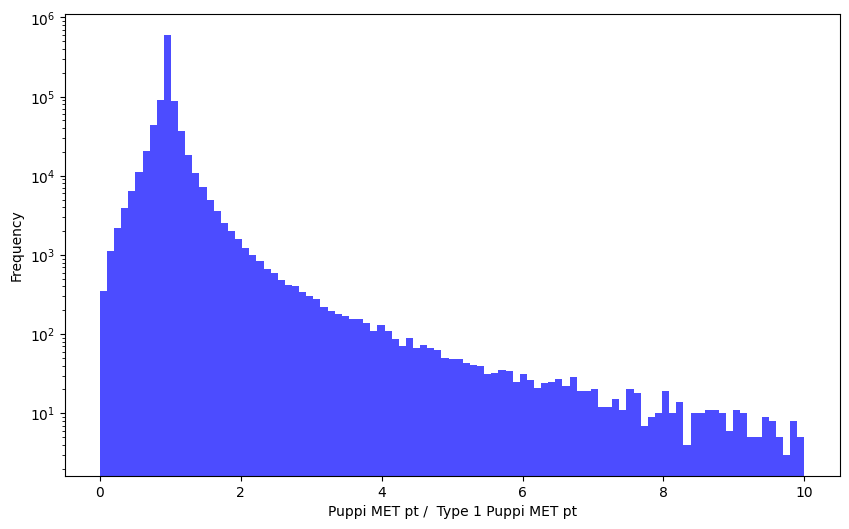

In [10]:
print(ratio_met)

print(np.mean(ratio_met))
print(np.median(ratio_met))

# plot histo of ratio_met
plt.figure(figsize=(10, 6))
plt.hist(ratio_met, bins=np.linspace(0., 10, 100), alpha=0.7, label='Ratio MET / Corrected MET', color='blue')
plt.yscale('log')
plt.xlabel('Puppi MET pt /  Type 1 Puppi MET pt')
plt.ylabel('Frequency')
plt.show()

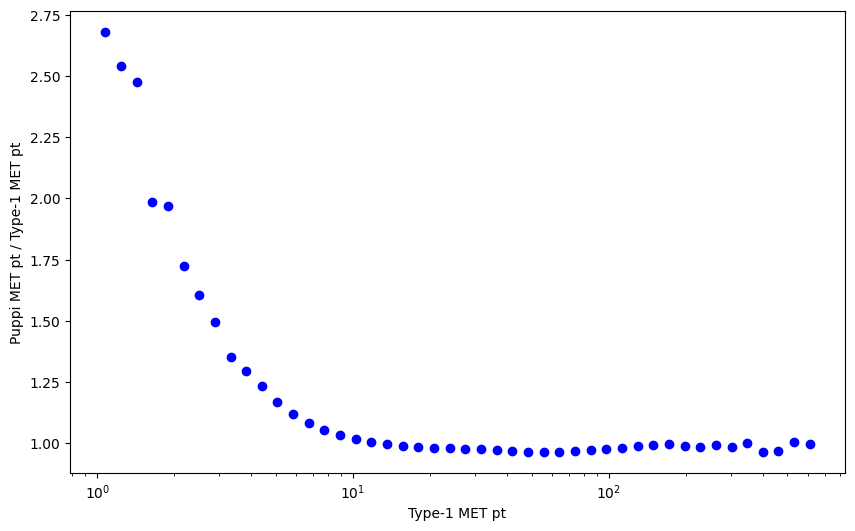

In [11]:
#plot the average of the ratio for different bins of cal_met
bins_met= np.logspace(0, 3, 50)  # Bins for MET pt from 1 to 1000
bin_means = []
bin_edges = []
for i in range(len(bins_met) - 1):
    mask = (cal_met.pt >= bins_met[i]) & (cal_met.pt < bins_met[i + 1])
    if ak.count(cal_met.pt[mask]) > 0:
        bin_mean = ak.mean(ratio_met[mask])
        bin_means.append(bin_mean)
        bin_edges.append((bins_met[i] + bins_met[i + 1]) / 2)
        
plt.figure(figsize=(10, 6))
plt.errorbar(bin_edges, bin_means, yerr=ak.std(ratio_met[mask]), fmt='o', label='Mean Ratio MET / Corrected MET', color='blue')
plt.xlabel('Type-1 MET pt')
plt.ylabel('Puppi MET pt / Type-1 MET pt')
plt.xscale('log')
plt.show()


In [12]:
low_pt_jet=events.CorrT1METJet.rawPt
print(low_pt_jet, ak.min(low_pt_jet))

# correct the met
# cal_met_low_pt = met_correction_after_jec(events, "RawPuppiMET", jet_raw, low_pt_jet)

[[8.48], [9.02], [10.5, 13.3, 8.55, ... 11.2, 8.84, 7.05], [8.45, 11.7, 10.1, 11.2]] 5.4960938


# Use the coffea MET factory